In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()

Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [53]:
import datajoint as dj
import pandas as pd
import subprocess
import numpy as np
import u19_pipeline.utils.path_utils as pu
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime

fig_size = (15,11)

## Calculate storage by date on main directories

In [5]:
folder_list_to_read_from = ['/mnt/cup/PNI-centers/Bezos/Ryan/', '/mnt/cup/PNI-centers/Bezos/Scott/twoP', '/mnt/cup/labs/witten/Scott/twoPhoton', '/mnt/cup/braininit/RigData/mesoscope/imaging', '/mnt/cup/PNI-centers/Bezos/RigData/scope/bay3/sakoay', '/mnt/cup/PNI-centers/Bezos/RigData/scope/bay3/edward', '/mnt/cup/braininit/RigData/training/npx/electrophysiology']

for idx, folder in enumerate(folder_list_to_read_from):
    print(idx, folder)
    if idx == 0:
        df_storage = pd.DataFrame(pu.get_size_directory_time(folder))
        df_storage['parent_folder'] = folder
    else:
        df_storage_current = pd.DataFrame(pu.get_size_directory_time(folder))
        df_storage_current['parent_folder'] = folder
        df_storage = df_storage.append(df_storage_current)

df_storage.reset_index(drop=True)
df_storage['size'] = df_storage['size'].astype(int)
df_storage['size'] = df_storage['size'].astype(int)
df_storage['size (TB)'] = df_storage['size']/(1024*1024*1024)
df_storage['date'] = pd.to_datetime(df_storage['date'])
df_storage['date'] = df_storage['date'].dt.normalize()
df_storage = df_storage.drop(['size', 'directory'], axis=1)
df_storage = df_storage.sort_values(by=['date'])
df_storage = df_storage.loc[df_storage['date'] > pd.to_datetime("'2018-01-01'".replace("'","")), :]
copy_df_storage = df_storage.copy()


0 /mnt/cup/PNI-centers/Bezos/Ryan/
1 /mnt/cup/PNI-centers/Bezos/Scott/twoP
2 /mnt/cup/labs/witten/Scott/twoPhoton
3 /mnt/cup/braininit/RigData/mesoscope/imaging
4 /mnt/cup/PNI-centers/Bezos/RigData/scope/bay3/sakoay
5 /mnt/cup/PNI-centers/Bezos/RigData/scope/bay3/edward
6 /mnt/cup/braininit/RigData/training/npx/electrophysiology


## Group storage by date, cumulative sum and plot

In [6]:
df_storage_day = df_storage.groupby(by=['date']).sum()
df_storage_day = df_storage_day.reset_index()
df_storage_day = df_storage.sort_values(by=['date'])
df_storage_day = df_storage_day.reset_index(drop=True)
df_storage_day['size (TB) sum'] = df_storage_day['size (TB)'].cumsum() 


## Log model prediction

In [97]:

df_storage_day_log = df_storage_day.loc[df_storage_day['size (TB) sum'] > 5, :]
df_storage_day_log.reset_index(drop=True)
df_storage_day_log['numeric_time'] = (df_storage_day_log['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

df_storage_day_log = df_storage_day_log.drop_duplicates(subset=['numeric_time'])

X = df_storage_day_log['numeric_time'].values
y = np.log(df_storage_day_log['size (TB) sum'].values) # Apply natural log function to the target

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
X2 = X
ini_date = df_storage_day_log.loc[df_storage_day_log.index[-1],'date']
for i in range(6):
    ini_date += pd.DateOffset(months=4)
    num_time = (ini_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    X2 = np.append(X2, num_time)

X2 = X2.reshape(-1, 1)
y_pred = np.exp(model.predict(X2)) # Apply exponential function (inverse of natural log) to the predictions


X2_date = pd.to_datetime(np.squeeze(X2),unit='s')
df_pred = pd.DataFrame(data=y_pred, index=X2_date, columns=['TB pred'])
df_pred.index.name = 'Date'
df_pred = df_pred.reset_index()
print('R^2', model.score(X, y))
print(df_storage_day_log.loc[df_storage_day_log.index[-1], 'size (TB) sum'])
df_pred.tail(8)





R^2 0.9692899273302676
183.24304355680943


,Date,TB pred
632,2021-11-29,196.370920
633,2021-11-30,196.858650
634,2022-03-30,265.114664
635,2022-07-30,358.812573
636,2022-11-30,486.831735
637,2023-03-30,655.628959
638,2023-07-30,887.344026
639,2023-11-30,1203.935606


## Log plot

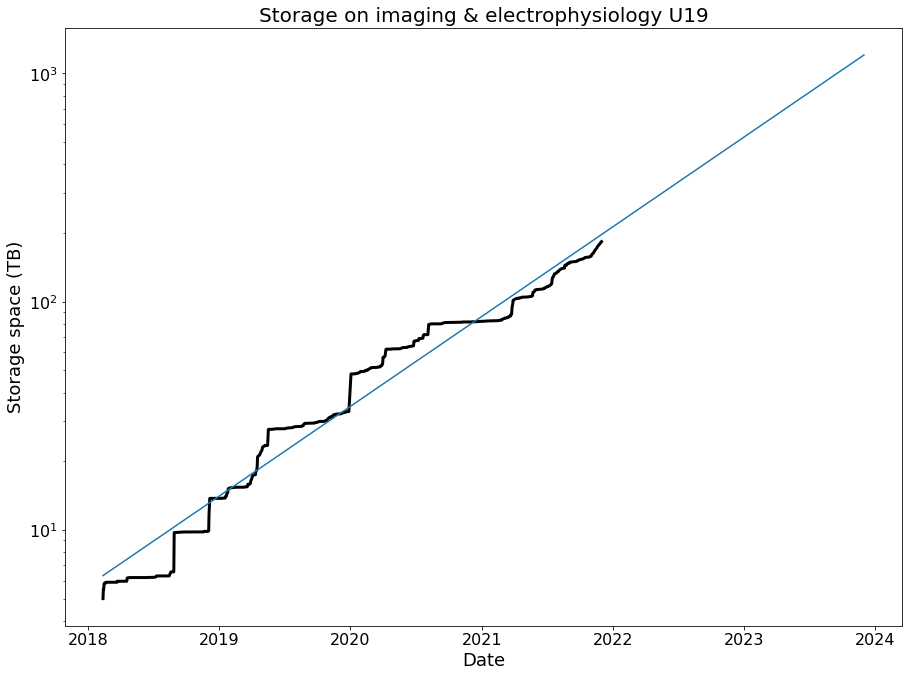

In [98]:
fig, axs = plt.subplots(1, 1, figsize=fig_size)

plt.plot(df_storage_day_log['date'] , df_storage_day_log['size (TB) sum'], linewidth=3, color ='k')
plt.plot(X2_date, y_pred) 
plt.yscale('log')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Storage space (TB)", fontsize=18);
plt.title('Storage on imaging & electrophysiology U19', fontsize=20);


## Linear model prediction

In [100]:
df_storage_day_lin = df_storage_day.loc[df_storage_day['date'] > pd.to_datetime('20210301', format='%Y%m%d'), :]
df_storage_day_lin.reset_index(drop=True)
df_storage_day_lin['numeric_time'] = (df_storage_day_lin['date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

df_storage_day_lin = df_storage_day_lin.drop_duplicates(subset=['numeric_time'])

X = df_storage_day_lin['numeric_time'].values
y = (df_storage_day_lin['size (TB) sum'].values) # Apply natural log function to the target

X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

model = LinearRegression()
model.fit(X, y)
X2 = X
ini_date = df_storage_day_log.loc[df_storage_day_log.index[-1],'date']
for i in range(6):
    ini_date += pd.DateOffset(months=4)
    num_time = (ini_date - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    X2 = np.append(X2, num_time)

X2 = X2.reshape(-1, 1)
y_pred = (model.predict(X2)) # Apply exponential function (inverse of natural log) to the predictions


X2_date = pd.to_datetime(np.squeeze(X2),unit='s')
df_pred = pd.DataFrame(data=y_pred, index=X2_date, columns=['TB pred'])
df_pred.index.name = 'Date'
df_pred = df_pred.reset_index()
print('R^2', model.score(X, y))
print(df_storage_day_log.loc[df_storage_day_log.index[-1], 'size (TB) sum'])
df_pred.tail(8)

R^2 0.973533157567027
183.24304355680943


,Date,TB pred
192,2021-11-29,172.397154
193,2021-11-30,172.724180
194,2022-03-30,211.967262
195,2022-07-30,251.864396
196,2022-11-30,292.088555
197,2023-03-30,331.331637
198,2023-07-30,371.228771
199,2023-11-30,411.452930


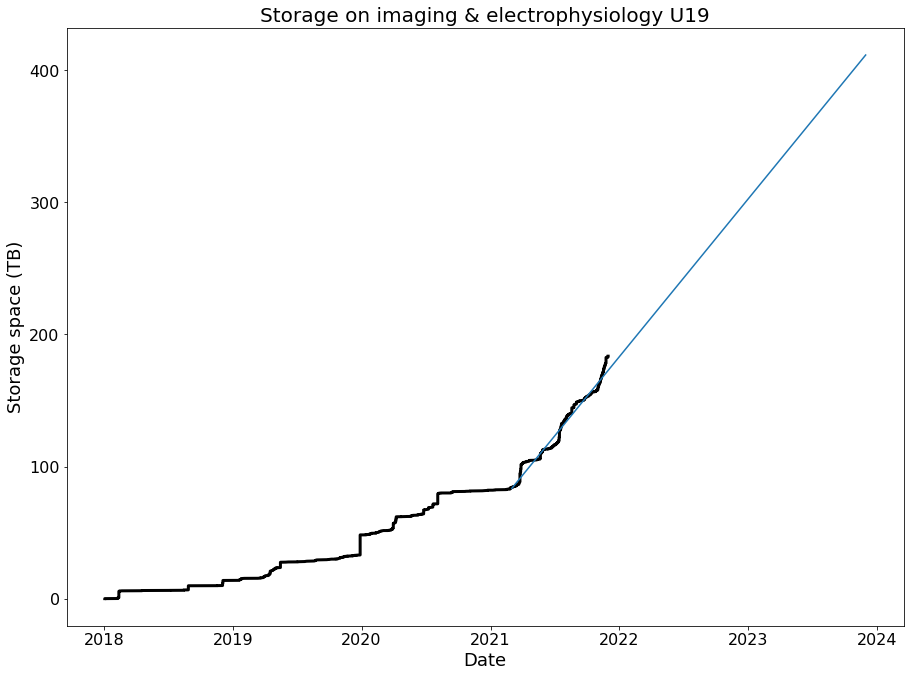

In [101]:
fig, axs = plt.subplots(1, 1, figsize=fig_size)

plt.plot(df_storage_day['date'] , df_storage_day['size (TB) sum'], linewidth=3, color ='k')
plt.plot(X2_date, y_pred) 


plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Storage space (TB)", fontsize=18);
plt.title('Storage on imaging & electrophysiology U19', fontsize=20);

## Get storage by year

In [6]:
df_storage_year = df_storage.copy()
df_storage_year = df_storage_year.sort_values(by=['date'])
df_storage_year['year'] = df_storage_year['date'].dt.year
df_storage_year = df_storage_year.groupby(df_storage_year['year']).sum()
df_storage_year = df_storage_year.reset_index()



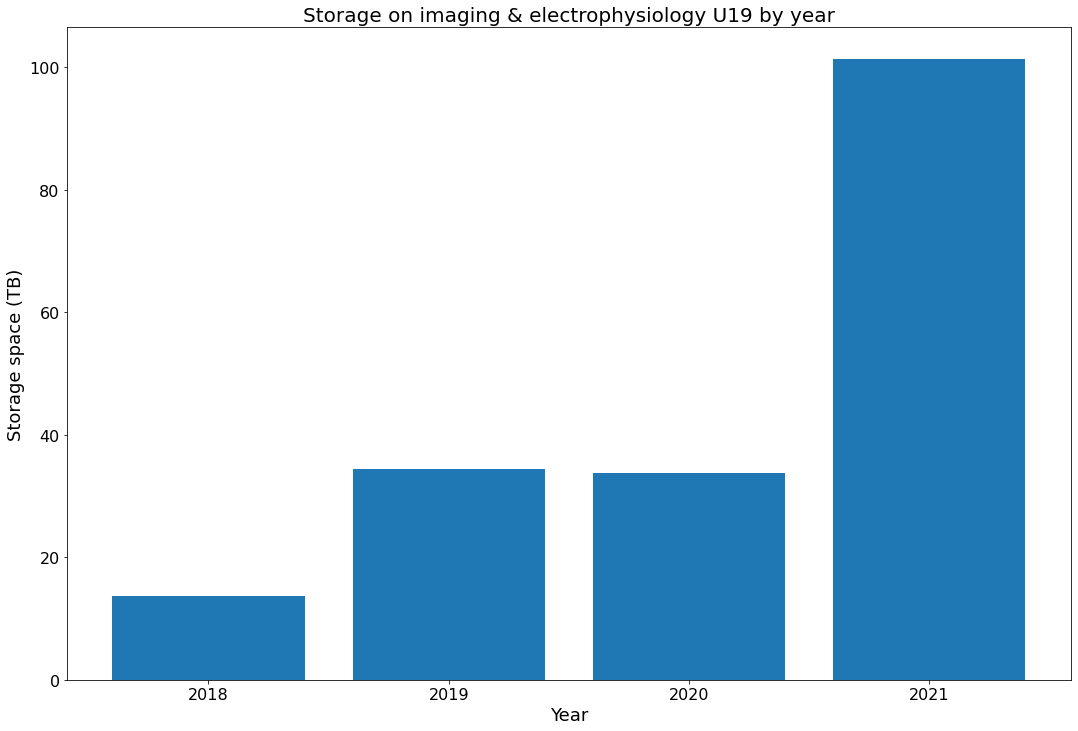

In [7]:
fig, axs = plt.subplots(1, 1, figsize=fig_size)

#plt.scatter(df_storage_day['date'] , df_storage_day['size (TB) sum'], s=100, color = 'k')
plt.bar(df_storage_year['year'], df_storage_year['size (TB)'])

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Year", fontsize=18)
plt.ylabel("Storage space (TB)", fontsize=18)
plt.title('Storage on imaging & electrophysiology U19 by year', fontsize=20)

all_years = df_storage_year['year'].values
axs.set_xticks(all_years);


## Get storage by main directories 

In [8]:
df_size_parent_folder = df_storage.groupby(by=['parent_folder']).sum()
df_size_parent_folder = df_size_parent_folder.reset_index()
df_size_parent_folder['parent_folder'] = df_size_parent_folder['parent_folder'].str.replace('/mnt/cup/', '')
df_size_parent_folder['parent_folder'] = df_size_parent_folder['parent_folder'].str.replace('braininit/RigData/', '')
df_size_parent_folder['parent_folder'] = df_size_parent_folder['parent_folder'].str.replace('PNI-centers/Bezos/RigData/', '')
df_size_parent_folder


,parent_folder,size (TB)
0,scope/bay3/edward,30.114159
1,scope/bay3/sakoay,38.274517
2,PNI-centers/Bezos/Ryan/,39.139867
3,PNI-centers/Bezos/Scott/twoP,25.611595
4,mesoscope/imaging,34.913119
5,training/npx/electrophysiology,7.631122
6,labs/witten/Scott/twoPhoton,7.811203


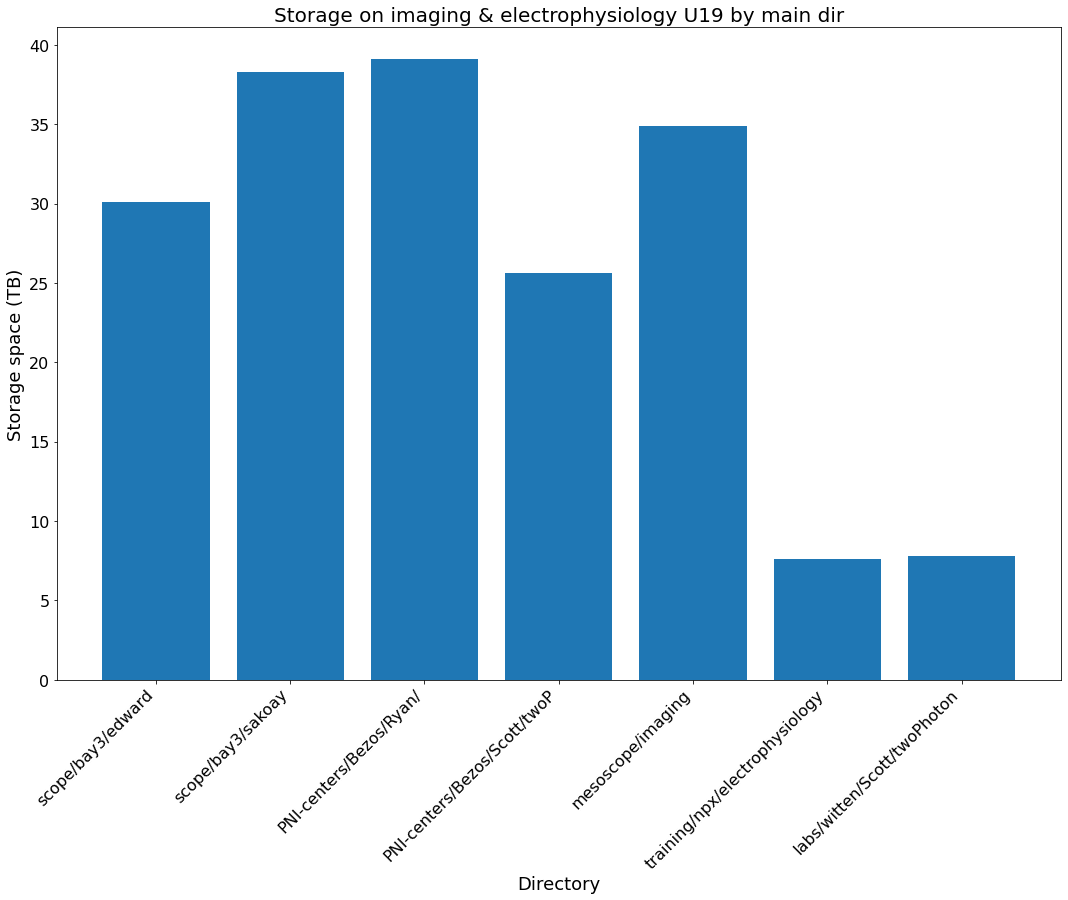

In [9]:
fig, axs = plt.subplots(1, 1, figsize=fig_size)
index = np.arange(df_size_parent_folder.shape[0])
plt.bar(index, df_size_parent_folder['size (TB)'])

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Directory", fontsize=18)
plt.ylabel("Storage space (TB)", fontsize=18)
plt.title('Storage on imaging & electrophysiology U19 by main dir', fontsize=20)

all_folders = df_size_parent_folder['parent_folder'].values
axs.set_xticks(index);
axs.set_xticklabels(all_folders, rotation = 45, ha="right");